In [27]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [28]:
config_var = 'SQLITE3_MULTI_GRID_RETINA'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = numpy


In [29]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 6 μs, sys: 1 μs, total: 7 μs
Wall time: 13.4 μs


((10000, 3), (2000, 3))


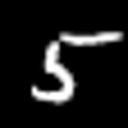
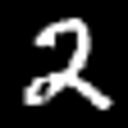
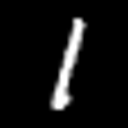
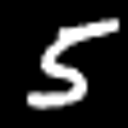
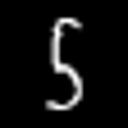
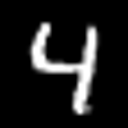
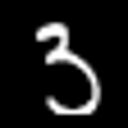
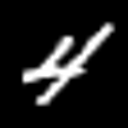
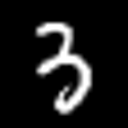
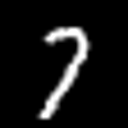
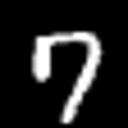
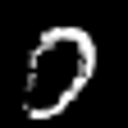
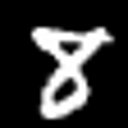
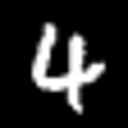
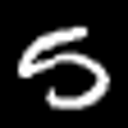
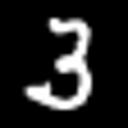

In [30]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [31]:
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, xp)

In [32]:
DIGITS = hdc(10)
DIGITS_NORM = hdc.normalize(DIGITS)

In [33]:
class CorticalColumn(object):
    def __init__(self):
        self.assoc_hdvs = HdvArray(hdc.N, xp, 100)

In [97]:
COLUMNS = {}
COLUMNS = {-1: CorticalColumn()}
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(config.cortical_columns_count)))
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

df_test_results = pd.DataFrame(columns=['source_ds', 'test_run_id', 'test_image_id', 'true_value', 'engram_id', 'infer_value', 'sim'])

In [107]:
a = np.array([[1, 1], [2, 2], [3, 3], [4, 4]])
# a = np.array([[1, 2], [3, 4], [5, 6]])
# np.compress([0, 0, 0, 1], a, axis=0)
np.take(a, [3,2,2,2,2,2,], axis=0)

array([[4, 4],
       [3, 3],
       [3, 3],
       [3, 3],
       [3, 3],
       [3, 3]])

In [101]:
# TRAIN RUN
TRAIN_RUN_ID += 1
epochs = 1
batch_size = 100
consolidation_cycles = 100
epoch_to_image_ids = defaultdict(lambda: RNG.choice(df_train_images.index.unique(), batch_size, replace=False))

for column_id, column in tqdm(COLUMNS.items(), desc='Columns'):
    for epoch in tqdm(range(epochs), leave=False, desc='Epoch'):
        # image_ids = epoch_to_image_ids[epoch]
        image_ids = [38700, 56837, 58875, 33761, 44563, 22108, 32724, 25144,  5028,
           52194, 17593, 25589, 13867, 52570, 30392, 45655, 16444, 44727,
           58452, 52462, 45871, 17939, 55446, 14845, 10976, 35683, 53563,
           18075,  5106, 56853, 44162, 43370, 57169,  3411, 57369,  2702,
            1289, 22414, 39521, 58116, 28560, 59179, 32486, 35707, 55107,
            1230, 49002, 50252, 30523, 28745, 56228, 51351, 56464,  1998,
           56498, 36711, 51729,  2296, 56351, 32518, 58665, 25612,  7938,
           57571, 43553, 11323, 35831,  8483, 35179,   716, 36277, 38890,
           17712, 52849, 24766,  7600, 41352, 28416,  5528, 15963, 13804,
            7581,  8443, 18899,  9700, 33560, 10599,  7171,  8149,  6733,
           27132, 56624, 50279, 15160, 31035, 10914, 18263, 43705,  3097,
           41313]
        short_memory = defaultdict(lambda: defaultdict(list))

        # ENGRAMS mining
        for image_no, image_id in tqdm(enumerate(image_ids), leave=True, total=len(image_ids), desc='Image (train)'):
            # log.debug(f'[train_run_id={TRAIN_RUN_ID}, image_no={image_no}, image_id={image_id}] Mappings count={COLUMN.engram_norms.len()}')
            image_value = df_train_images.loc[image_id]['value']
            df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                             params={'image_id': int(image_id), 'column_id': column_id}, 
                                             con=train_db_con)
            assert len(df_image_encodings) > 0
            image_encoding_hdvs = xp.vstack(list(map(lambda h: xp.frombuffer(h, dtype='b'), df_image_encodings['hdv'])))
            # map_results = xp.einsum('ij,kj->ikj', column.assoc_hdvs.array, image_encoding_hdvs)
            image_encoding_hdv_bundle = hdc.bundle(image_encoding_hdvs) # TODO generate bundles in prep_dataset
            ОБРАБАТЫВАТЬ ТОЛЬКО ЗАНЯТЫЕ элементы в assoc_hdvs! Плюс чтобы был предсказуемый индексинг
            assoc_results = column.assoc_hdvs.array * image_encoding_hdv_bundle
            assert assoc_results.shape == (column.assoc_hdvs.array.shape[0], hdc.N)
            assoc_results_norm = hdc.normalize(assoc_results)

            l = xp.linalg.norm(assoc_results, axis=1)
            assert xp.all(l > 0), l
            
            digits_proximity = assoc_results_norm @ DIGITS_NORM.T
            digits_proximity_indices_recognized = xp.argwhere(digits_proximity >= COS_SIM_THRESHOLD)
    
            if digits_proximity_indices_recognized.size == 0:
                # No association (mapping) exists that connects to known entity (digit) :=( => create new one
                source_hdv = image_encoding_hdv_bundle
                target_hdv = DIGITS[int(image_value)]
                assoc_hdv_index = column.assoc_hdvs.lease()
                column.assoc_hdvs.array[assoc_hdv_index] = hdc.bind(source_hdv, target_hdv)
                short_memory[int(image_value)]['source_hdvs'].append(source_hdv)
                short_memory[int(image_value)]['assoc_hdv_indices'].append(assoc_hdv_index)
            else:
                for digit_proximity_index in digits_proximity_indices_recognized:
                    assoc_index = digit_proximity_index[0]
                    target_hdv_index = int(digit_proximity_index[1])
                    source_hdv = image_encoding_hdv_bundle
                    short_memory[target_hdv_index]['source_hdvs'].append(source_hdv)
                    short_memory[target_hdv_index]['assoc_hdv_indices'].append(assoc_index)

        for target_hdv_index, tab in short_memory.items():
            tab['source_hdvs'] = xp.array(tab['source_hdvs'])
            tab['assoc_hdv_indices'] = list(set(tab['assoc_hdv_indices'])) # get rid of duplicates
            assert len(tab['assoc_hdv_indices']) > 0
            tab['assoc_hdvs'] = xp.take(column.assoc_hdvs.array, tab['assoc_hdv_indices'] , axis=0)

        # # ENGRAMS consolidation
        # for _ in range(consolidation_cycles):
        #     for target_hdv_index, tab in short_memory:
        #         # Here we have all source HDVs associated with SINGLE taget_hdv via assoc_hdvs.
        #         # Our goal is to optimize associations by bundling them together,
        #         # but without breaking associations. The latter (breaking) could happen because
        #         # we could have several distinct clusters (say A, B, C) which map to X.
        #         # Should we bundle all these cluster into one megabundle then some of associations will get broken
        #         assoc_results = xp.einsum('ij,kj->ikj', tab['source_hdvs'], tab['assoc_hdvs']) # batch bind (map) source hdvs via assoc_hdvs
        #         # all source hdvs still should get lead to the same SINGLE target_hdv via assoc hdvs
        #         assoc_results_shape = assoc_results.shape
        #         assoc_results = assoc_results.reshape(-1, hdc.N)
        #         assoc_results_norm = hdc.normalize(assoc_results)
        #         target_hdv = DIGITS_NORM[target_hdv_index]
        #         digits_proximity = assoc_results_norm @ target_hdv
        #         digits_proximity = digits_proximity.reshape(assoc_results_shape[0], assoc_results_shape[1])
        #         assert xp.all(xp.max(digits_proximity, axis=1) >= COS_SIM_THRESHOLD)
                
                
                
                
                
            

        
                
            
            
        

        

Columns:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

In [102]:
image_no

0

In [66]:
df_z = df_train_images.loc[list(epoch_to_image_ids[0])]
df_z[df_z['value'] == '1']

,index,value,png
image_id,,,
59545,65,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
44886,3034,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
42182,1694,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
27677,9529,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
27202,5135,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
17587,380,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [91]:
epoch_to_image_ids[0]

array([38700, 56837, 58875, 33761, 44563, 22108, 32724, 25144,  5028,
       52194, 17593, 25589, 13867, 52570, 30392, 45655, 16444, 44727,
       58452, 52462, 45871, 17939, 55446, 14845, 10976, 35683, 53563,
       18075,  5106, 56853, 44162, 43370, 57169,  3411, 57369,  2702,
        1289, 22414, 39521, 58116, 28560, 59179, 32486, 35707, 55107,
        1230, 49002, 50252, 30523, 28745, 56228, 51351, 56464,  1998,
       56498, 36711, 51729,  2296, 56351, 32518, 58665, 25612,  7938,
       57571, 43553, 11323, 35831,  8483, 35179,   716, 36277, 38890,
       17712, 52849, 24766,  7600, 41352, 28416,  5528, 15963, 13804,
        7581,  8443, 18899,  9700, 33560, 10599,  7171,  8149,  6733,
       27132, 56624, 50279, 15160, 31035, 10914, 18263, 43705,  3097,
       41313])

In [ ]:
df_train_images.loc[list(epoch_to_image_ids[0])]['value'].unique()

In [90]:
column.assoc_hdvs.len()

15

In [74]:
list(short_memory.keys())

[1, 4, 5, 2, 7, 8, 6, 9, 0, 3]


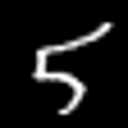

In [13]:
images = []
captions = []

if COLUMN.engrams.keys():
    random_engram_i = RNG.choice(list(COLUMN.engrams.keys()))
    image_ids = COLUMN.engram_to_image_ids[random_engram_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_engram_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))

images = images[:32]
captions = captions[:32]
display_images_grid(images, captions=captions, col_count=8)

In [27]:
# TEST RUN
TEST_RUN_ID += 1
count = 2000
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)

for image_id in tqdm(test_image_ids):
    max_cos_sim_index = -1 # aka engram id
    max_similar_engram_image_value = ''
    max_cos_sim = 0

    image_value = test_run_source[0].loc[image_id]['value']
    df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_run_source[1])
    assert len(df_image_encodings) > 0
    image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
    image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
    image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

    cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
    cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
    cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
    
    assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
    engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

    if engram_ids_by_match_score.shape[0] > 0:
        engram_id = engram_ids_by_match_score[0]
        cos_sim_value = cos_sim_vector[engram_id]

        # if cos_sim_value >= COS_SIM_THRESHOLD:
        if cos_sim_value > 0:
            engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
            assert len(engram_image_ids) > 0
            engram_image_id = next(iter(engram_image_ids))
            engram_image_value = df_train_images.loc[engram_image_id]['value']
            max_cos_sim_index = engram_id
            max_similar_engram_image_value = engram_image_value
            max_cos_sim = cos_sim_value
    
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_id'].append(max_cos_sim_index)
    test_result_rows['infer_value'].append(max_similar_engram_image_value)
    test_result_rows['sim'].append(max_cos_sim)
    

assert set(test_result_rows.keys()) == set(df_test_results.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=df_test_results.columns)
concat_list = [df_test_results] if len(df_test_results) > 0 else []
concat_list.append(df_test_results_for_run)
df_test_results = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

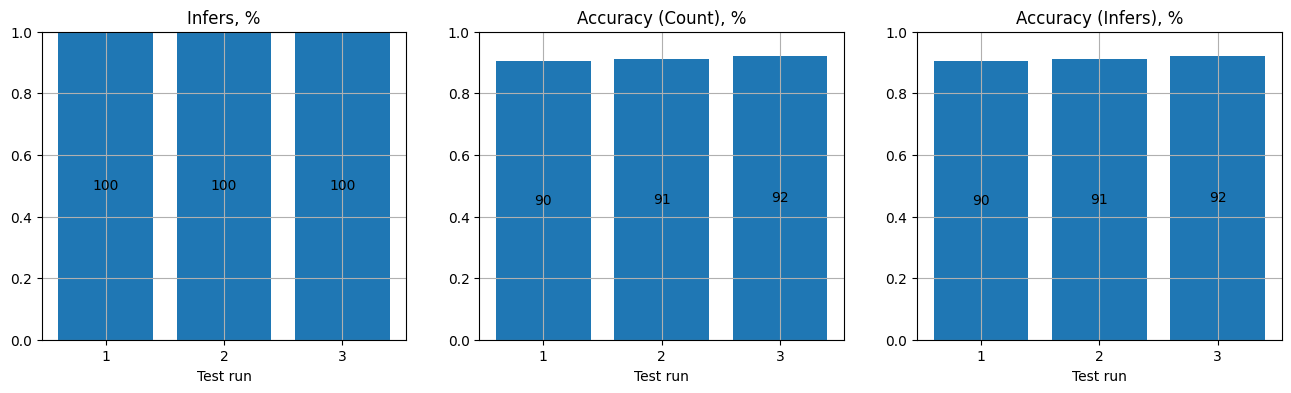

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,
1,2000,2000,1809,1.0,0.9045,0.9045
2,2000,2000,1824,1.0,0.9120,0.9120
3,2000,2000,1843,1.0,0.9215,0.9215


In [28]:
df_test_results2 = df_test_results.copy()
df_test_results2['is_infer'] = df_test_results2['engram_id'] > -1
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'test_image_id': 'count', 'is_infer': 'sum', 'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [17]:
df_test_results_incorrect_infers = df_test_results_for_run[df_test_results_for_run['true_value'] != df_test_results_for_run['infer_value']]
incorrect_infer_row_index = RNG.choice(df_test_results_incorrect_infers.index.unique())
test_run_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']
incorrect_infer_image_id = df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_image_id']
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image_value = test_run_source[0].loc[incorrect_infer_image_id]['value']

df_x = pd.DataFrame(columns=['test_run_id', 'test_image_id', 'true_value', 'engram_id', 'engram_value', 'sim'])
df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(incorrect_infer_image_id)}, con=test_run_source[1])
assert len(df_image_encodings) > 0
image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)

cos_sim_matrix = COLUMN.engram_norms.array @ image_encoding_hdvs_norm.T
cos_sim_matrix[cos_sim_matrix < COS_SIM_THRESHOLD] = 0
cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image

assert cos_sim_vector.shape == (COLUMN.engram_norms.array.shape[0],)
engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc

for pos, engram_id in enumerate(engram_ids_by_match_score):
    cos_sim_value = cos_sim_vector[engram_id]

    if cos_sim_value <= 0:
        break
        
    engram_image_ids = COLUMN.engram_to_image_ids[engram_id]
    assert len(engram_image_ids) > 0
    engram_image_id = next(iter(engram_image_ids))
    engram_image_value = df_train_images.loc[engram_image_id]['value'] # exactly from train! (i.e. we look for prototype in train data)
    df_x.loc[len(df_x)] = [test_run_id, incorrect_infer_image_id, image_value, engram_id, engram_image_value, cos_sim_value]

df_x.sort_values(by='sim', ascending=False).head(10)

,test_run_id,test_image_id,true_value,engram_id,engram_value,sim
0,1,100002322,5,79,3,3.862693
1,1,100002322,5,20,8,3.840800
2,1,100002322,5,233,5,3.744116
3,1,100002322,5,200,5,3.571549
4,1,100002322,5,237,5,3.424872
5,1,100002322,5,1,5,3.314627
6,1,100002322,5,47,3,3.269252
7,1,100002322,5,163,3,3.015236
8,1,100002322,5,196,5,2.974074
9,1,100002322,5,2,3,2.696484



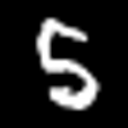

In [18]:
image_data = test_run_source[0].loc[incorrect_infer_image_id]['png']
image = Image.open(io.BytesIO(image_data))
label = test_run_source[0].loc[incorrect_infer_image_id]['value']
display_images([image], captions=[label])

In [19]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='sum'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [20]:
df_x_pivot = pd.pivot_table(df_x, index='engram_id', 
                            values=['true_value', 'engram_value', 'sim'], 
                            aggfunc=dict(engram_value='first', true_value='first', sim='max'))
df_x_pivot.sort_values(by='sim', ascending=False)

,engram_value,sim,true_value
engram_id,,,
79,3,3.862693,5
20,8,3.840800,5
233,5,3.744116,5
200,5,3.571549,5
237,5,3.424872,5
...,...,...,...
288,4,0.056177,5
146,3,0.055770,5
320,2,0.055655,5


In [21]:
df_test_results_incorrect_infers.loc[incorrect_infer_row_index]['test_run_id']

np.int64(1)

In [22]:
incorrect_infer_row_index

np.int64(396)